In [1]:
#import packages
import pandas as pd
import numpy as np
from datetime import datetime
#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df = pd.read_csv('NSE-TATAGLOBAL11.csv')

#print the head
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,10/8/2018,208.00,222.25,206.85,216.00,215.15,4642146,10062.83
1,10/5/2018,217.00,218.60,205.90,210.25,209.20,3519515,7407.06
2,10/4/2018,223.50,227.80,216.15,217.25,218.20,1728786,3815.79
3,10/3/2018,230.00,237.50,225.75,226.45,227.60,1708590,3960.27
4,10/1/2018,234.55,234.60,221.05,230.30,230.90,1534749,3486.05


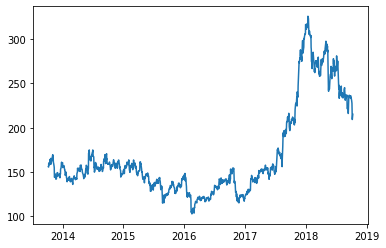

In [2]:
#setting index as date
df['Date'] = pd.to_datetime(df.Date,format='%m/%d/%Y')
df.index = df['Date']

#plot
#plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In [3]:
from statsmodels.tsa.arima_model import ARMA
from random import random


In [4]:
#creating dataframe with date and the target variable
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]
#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

In [5]:
#splitting into train and validation
train = new_data[:987]
valid = new_data[987:]

In [6]:
new_data.shape, train.shape, valid.shape

((1235, 1), (987, 1), (248, 1))

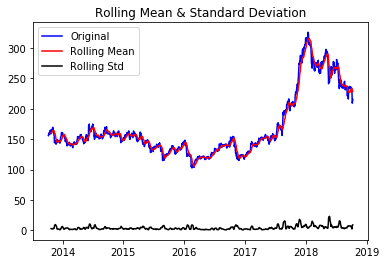

In [7]:
    #Determing rolling statistics
rolmean = new_data.rolling(window=12).mean()
rolstd = new_data.rolling(window=12).std()
#Plot rolling statistics:
plt.plot(new_data, color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

In [8]:
from pandas import Series
from statsmodels.tsa.stattools import adfuller
print('Results of the Dicky-fuller Test:')
dftest=adfuller(valid['Close'],autolag='AIC')
dfoutput=pd.Series(dftest[:4], index=['test-statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key]=value
    
print(dfoutput)


Results of the Dicky-fuller Test:
test-statistic                  -1.742531
p-value                          0.409343
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


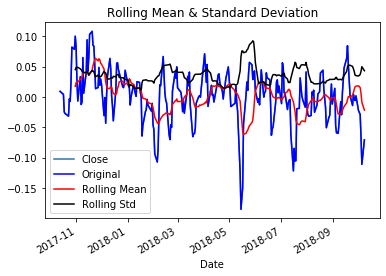

In [9]:
#transformation
from datetime import datetime
new_data_log= valid['Close'].astype(np.float64).apply(np.log)
new_data_diff= new_data_log- new_data_log.shift(4)--
new_data_diff.dropna().plot()

#Determing rolling statistics
rolmean = new_data_diff.rolling(window=12).mean()
rolstd = new_data_diff.rolling(window=12).std()
#Plot rolling statistics:
plt.plot(new_data_diff, color='blue',label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')``````````````````````
plt.title('Rolling Mean & Standard Deviation')
plt.show()

In [10]:
from pandas import Series
from statsmodels.tsa.stattools import adfuller
print('Results of the Dicky-fuller Test:')
dftest=adfuller(new_data_diff.dropna(),autolag='AIC')
dfoutput=pd.Series(dftest[:4], index=['test-statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key]=value
    
print(dfoutput)


Results of the Dicky-fuller Test:
test-statistic                  -3.486486
p-value                          0.008341
#Lags Used                      13.000000
Number of Observations Used    230.000000
Critical Value (1%)             -3.459106
Critical Value (5%)             -2.874190
Critical Value (10%)            -2.573512
dtype: float64


In [11]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [27]:
lag_acf = acf(new_data_diff.dropna(), nlags=10)
lag_pacf = pacf(new_data_diff.dropna(), nlags=10, method='ols')

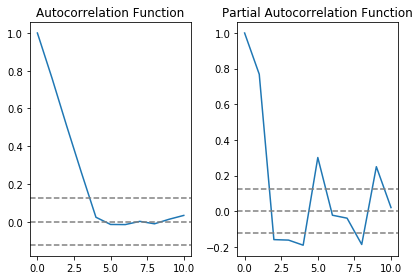

In [28]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_data_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_data_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(new_data_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(new_data_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 0.1537')

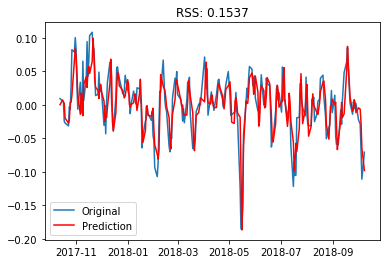

In [29]:
model = ARMA(new_data_diff.dropna(), order=(3, 2))  
results_ARMA = model.fit(disp=-1)
plt.plot(new_data_diff.dropna(), label='Original')
plt.plot(results_ARMA.fittedvalues, color='red', label='Prediction')
plt.legend(loc='best')
plt.title('RSS: %.4f'% sum((results_ARMA.fittedvalues-new_data_diff.dropna())**2))


In [30]:
rms=np.sqrt(np.mean(np.power((new_data_diff),2)))
rms-

0.04488899584797455